In [1]:
import pandas as pd
import regex as re
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

### Loading in the full 2025 Crowd Counting Datasets

In [2]:
# there are some unique encodings in the data set so we must use a more flexible encoding than utf-8
crowd_data = pd.read_csv("ignore_folder/dataverse_files/ccc_compiled_20212024.csv", encoding='latin-1')
crowd_data.drop(columns=['source_1', 'source_2',
       'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8',
       'source_9', 'source_10', 'source_11', 'source_12', 'source_13',
       'source_14', 'source_15', 'source_16', 'source_17', 'source_18',
       'source_19', 'source_20', 'source_21', 'source_22', 'source_23',
       'source_24', 'source_25', 'source_26', 'source_27', 'source_28',
       'source_29', 'source_30', 'notes', 'lat', 'lon', 'resolved_locality',
       'resolved_county', 'resolved_state', 'fips_code'], inplace=True)

/var/folders/tg/8kb0ckt5513401vpr0334d640000gn/T/ipykernel_80198/2101564465.py:2: DtypeWarning: Columns (22,24,26,33,34,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data = pd.read_csv("ignore_folder/dataverse_files/ccc_compiled_20212024.csv", encoding='latin-1')


### Trimming Down to correct dates

In [3]:
crowd_data['date'] = pd.to_datetime(crowd_data['date'])
start_date = pd.to_datetime("2024-03-1")
end_date = pd.to_datetime("2024-08-31")
mask = (crowd_data['date'] >= start_date) & (crowd_data['date'] <= end_date)
crowd_data = crowd_data[mask]

### Only Taking Events realated to the campus protests

In [15]:
key_phrases = ['divest', 'israel', 'palestine', 'divestment', 'liberation', 'palestinian', 'gaza', 'genocide']
regex = '|'.join(key_phrases)
crowd_data['claims'] = crowd_data['claims'].str.lower()
mask = crowd_data['claims'].str.contains(regex)
crowd_data = crowd_data[mask]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

### Dropping Unnecessary Columns

In [ ]:
crowd_data.drop(columns = ['locality', 'state', 'location_detail', 'online', 'type',
       'title', 'macroevent', 'organizations', 'participants', 'claims',
       'claims_summary', 'claims_verbatim', 'issue_tags_summary',
       'issue_tags_verbatim', 'issue_tags', 'valence',
       'size_cat', 'property_damage', 'property_damage_any',
       'chemical_agents', 'arrests_any', 'injuries_crowd_any', 'injuries_police_any', 'participant_deaths',
       'police_deaths', 'size_text'], inplace=True)

: 

: 

: 

### Parsing of mixed data types

In [ ]:
def parse_mixed(value):
    #NA case
    if pd.isna(value):
        return 0
    
    #value is already a number
    if isinstance(value, int) or isinstance(value, float):
        return float(value)
    
    #unclear/unspecified
    pattern = r'unspecified|unclear'
    if re.search(pattern, value):
        return pd.NA  # you can later impute with mean/median nonzero
    
    #"above value" case (in this just do 1 more than the value for a lower bound)
    pattern = r'(?:more than|over)\s+(\d+)'
    match = re.findall(pattern, value)
    if len(match) > 0:
        return float(match[0]) + 1
    
    #single number case
    pattern = r'(\d+)'
    match = re.findall(pattern, value)
    if len(match) > 0:
        return float(match[0])
    
    #catch all case
    return pd.NA


: 

: 

: 

In [ ]:
crowd_data['injuries_crowd'] = crowd_data['injuries_crowd'].apply(parse_mixed)
crowd_data['arrests'] = crowd_data['arrests'].apply(parse_mixed)
crowd_data['injuries_police'] = crowd_data['injuries_police'].apply(parse_mixed)
crowd_data['participant_measures'] = crowd_data['participant_measures'].astype(str)
crowd_data['police_measures'] = crowd_data['participant_measures'].astype(str)
print(crowd_data.columns)

Index(['date', 'size_low', 'size_high', 'size_mean', 'arrests',
       'injuries_crowd', 'injuries_police', 'participant_measures',
       'police_measures'],
      dtype='object')


: 

: 

: 

### Aggregate the same days together by summing the counts and concatenating the strings of measures

In [ ]:
agg_dict = {
    'size_low': 'sum',
    'size_high': 'sum',
    'size_mean': 'sum',
    'arrests': 'sum',
    'injuries_crowd': 'sum',
    'injuries_police': 'sum',
    'participant_measures': lambda x: ' ; '.join(x),
    'police_measures': lambda x: ' ; '.join(x)
}

crowd_data = crowd_data.groupby('date').agg(agg_dict)

: 

: 

: 

### Removing Outliers

<AxesSubplot: xlabel='date'>

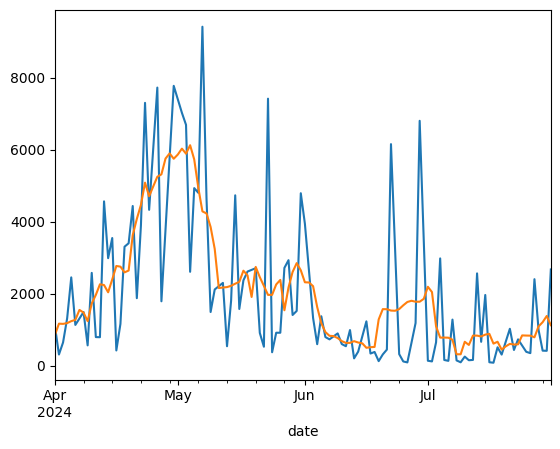

: 

: 

: 

In [ ]:
numeric_columns = ['size_low', 'size_high', 'size_mean', 'arrests', 'injuries_crowd',
       'injuries_police']
mean_sizes = crowd_data['size_mean'].copy()
q1 = mean_sizes.quantile(0.25)
q3 = mean_sizes.quantile(0.75)
IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Mask for outliers
outlier_mask = (mean_sizes < lower_bound) | (mean_sizes > upper_bound)

# Replace outliers with NaN for smoothing
crowd_data.loc[outlier_mask, numeric_columns] = np.nan
crowd_data[numeric_columns] = crowd_data[numeric_columns].interpolate(method='linear')

crowd_data['size_mean'].plot()

smoothed_data = crowd_data.copy()
smoothed_data[numeric_columns] = smoothed_data[numeric_columns].rolling(window=7, center=True, min_periods=1).mean()  # rolling smoothing
smoothed_data['size_mean'].plot()

### Exporting the dataset as a csv

In [ ]:
crowd_data.to_csv("palprot24.csv")
smoothed_data.to_csv("smoothpalprot24.csv")``

: 

: 

: 

<AxesSubplot: xlabel='date'>

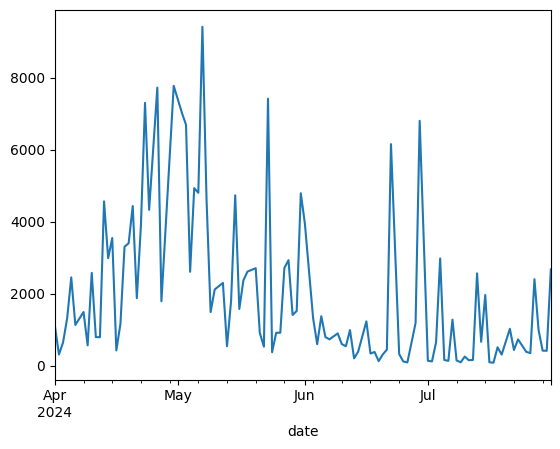

: 

: 

: 

In [ ]:
crowd_data = pd.read_csv("palprot24.csv", index_col=0, parse_dates=True)
crowd_data['size_mean'].plot()